# Initial configuration

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
CACHE_DIR = "/scratch/chaijy_root/chaijy0/sstorks/.cache/"

# CaptainCook4D

In [ ]:
VIDEO_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv" # Directory containing CaptainCook4D mp4s
ANNOTATIONS_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/annotations"

Boilerplate code to load video frames from video files (from GPT4):

In [ ]:
import cv2
import numpy as np

def get_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Cannot open video file")
    
    return cap
    # remember to call cap.release() later

def extract_frames(cap, times):
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frames = []

    for t in times:
        frame_number = int(t * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Convert to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frames.append(frame)
        else:
            print(f"Warning: Frame at time {t} seconds could not be read.")
            frames.append(None)

    return frames

Other utils functions:

In [36]:
def generate_float_series(start, end, step):
    # Ensure step is a positive float
    step = abs(step)

    # Initialize the series with the start value
    series = [start]

    # Generate numbers in the series
    while start + step <= end:
        start += step
        series.append(start)

    # Check if the end value is already in the series
    if series[-1] != end:
        series.append(end)

    return series

Sample video: /nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv/7_35_360p.mp4


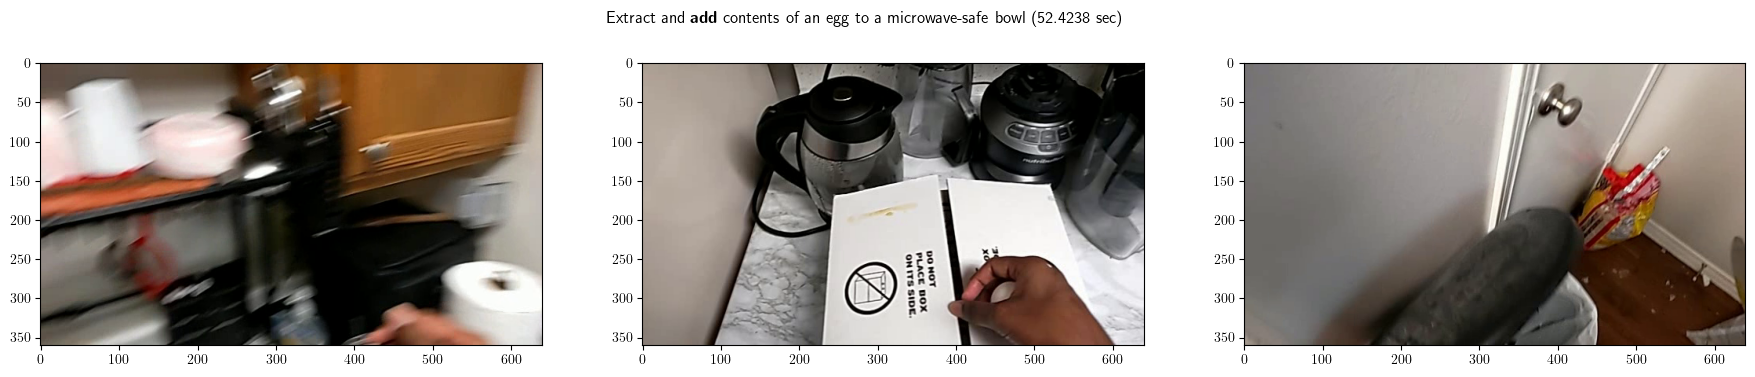

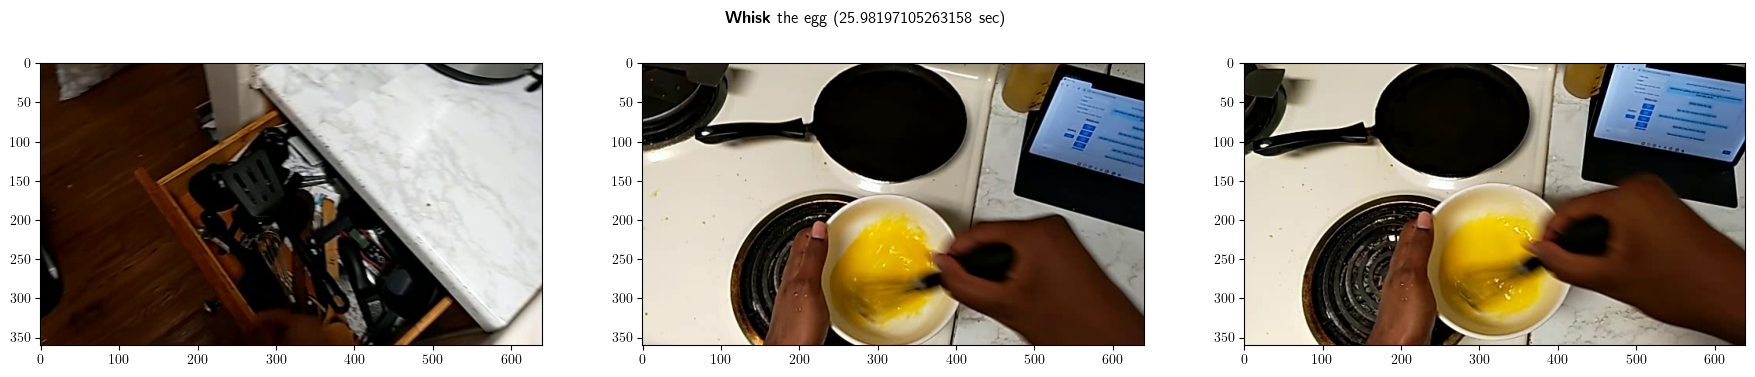

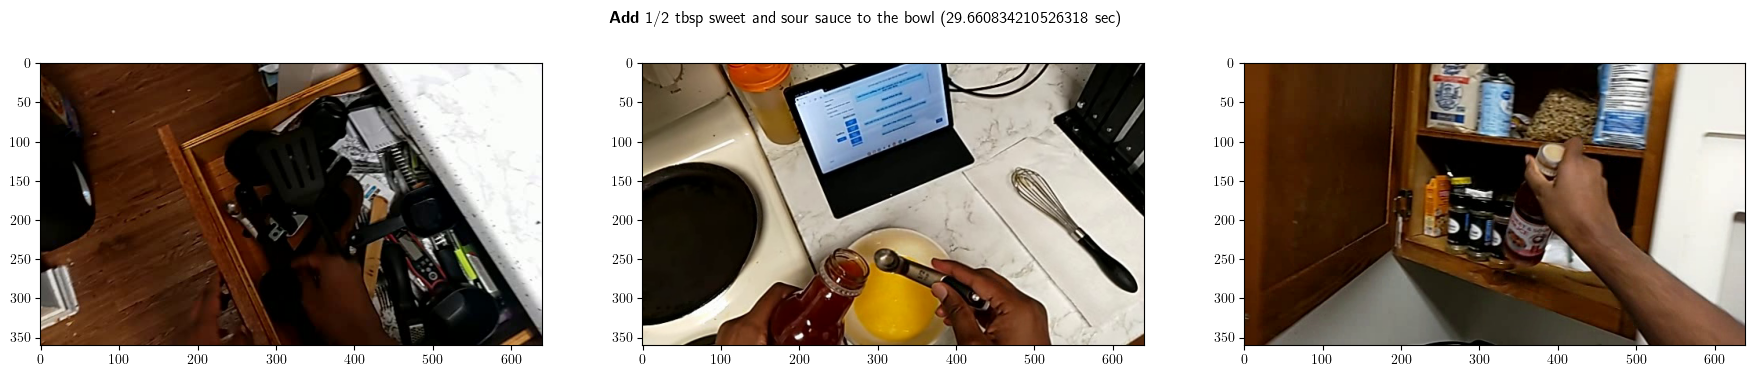

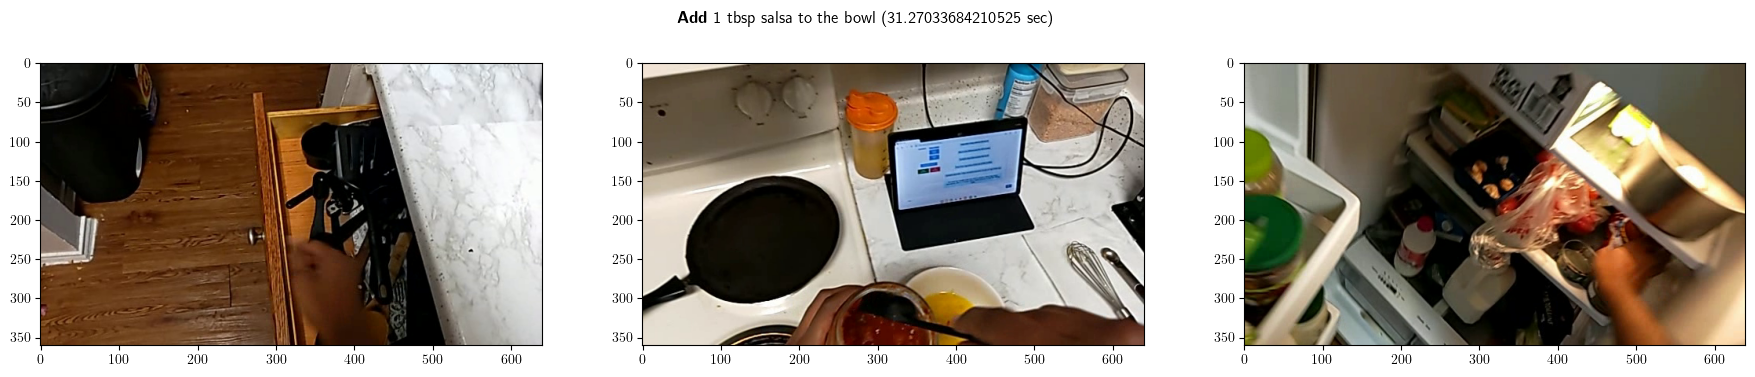

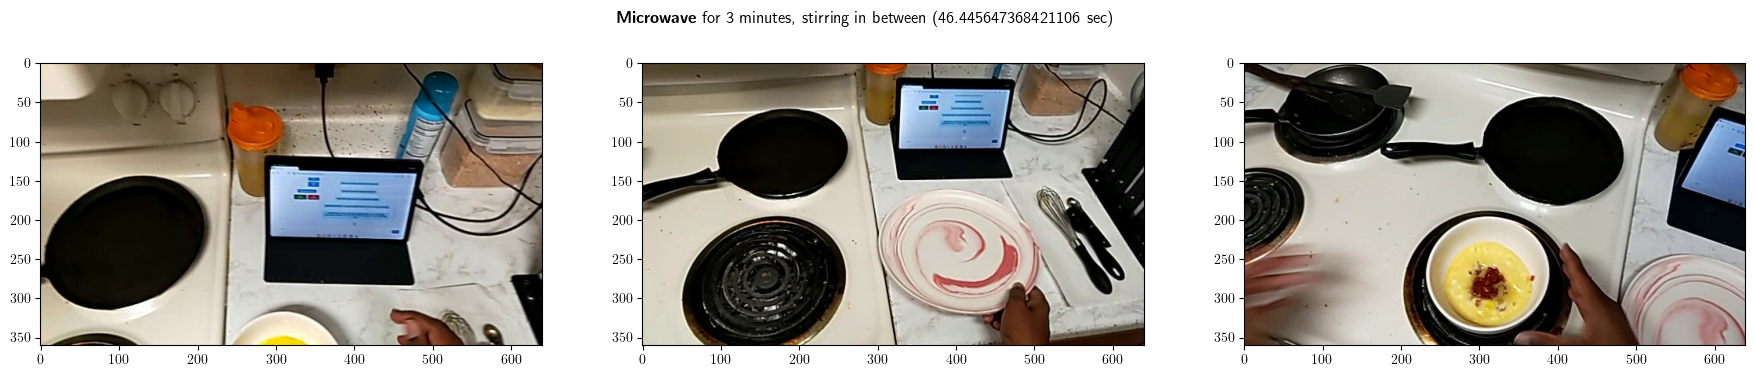

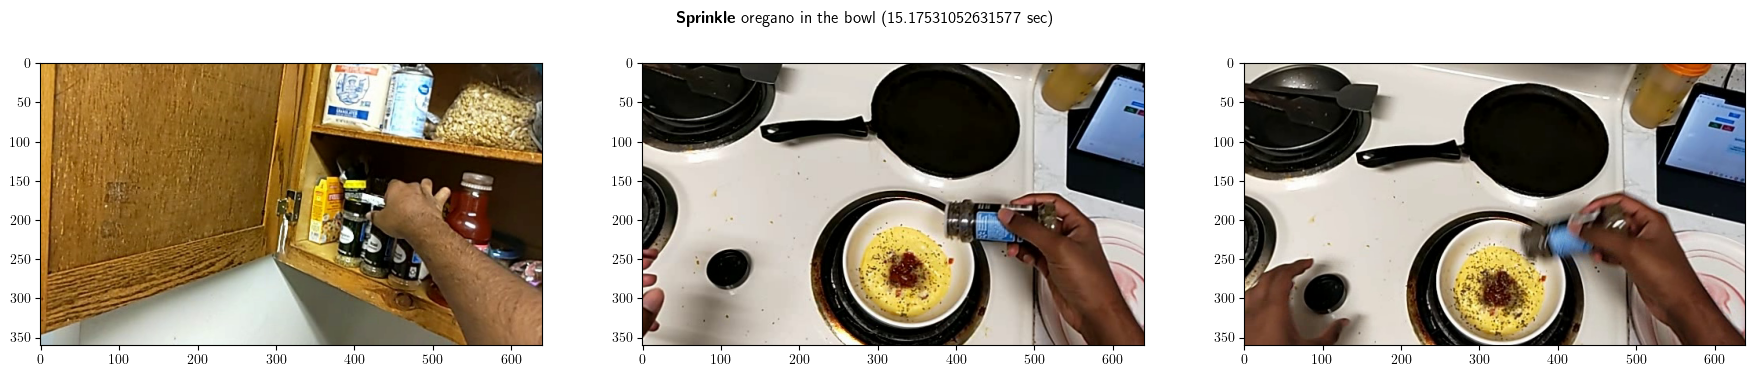

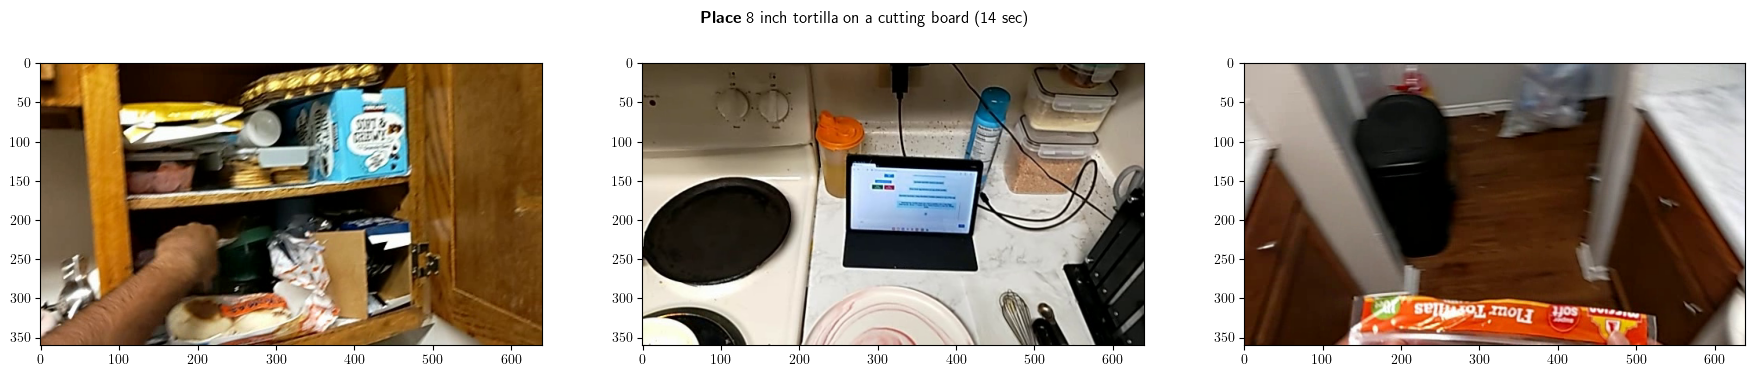

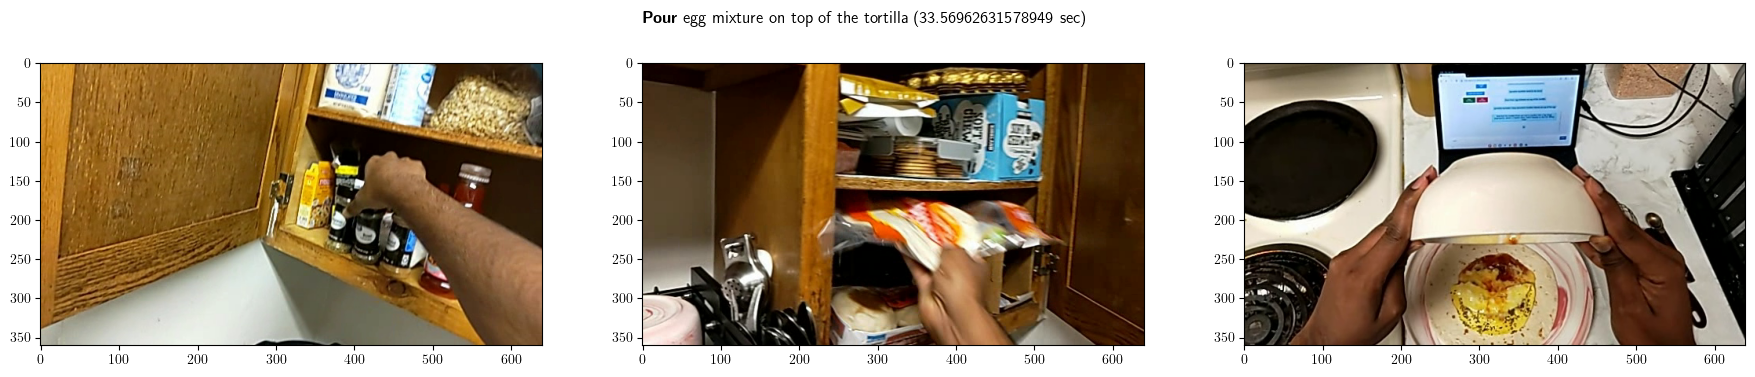

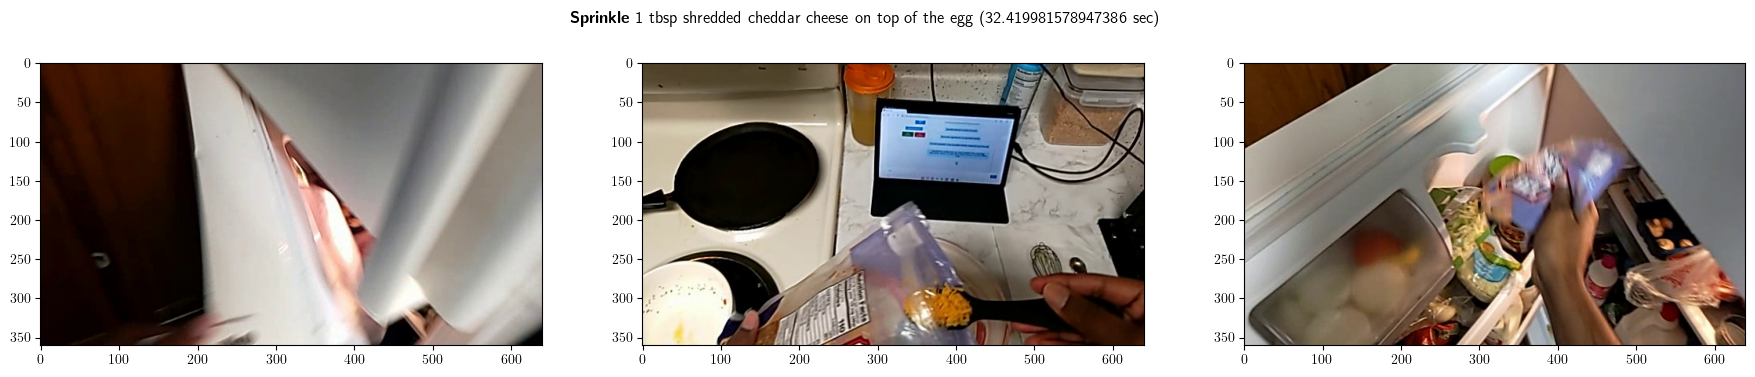

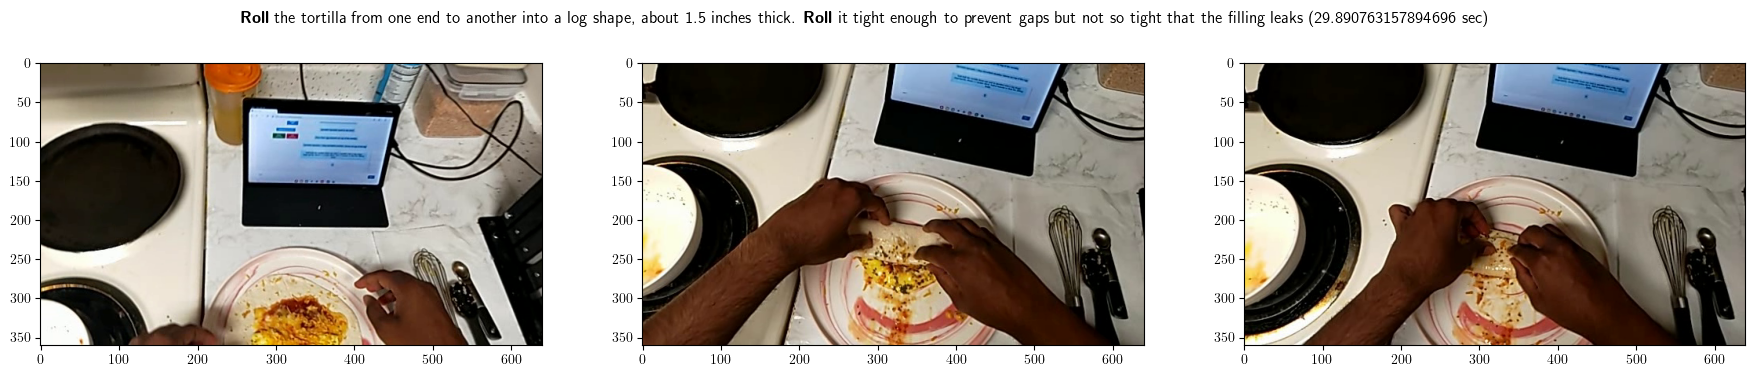

In [56]:
import os, json
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# Pick a sample video from CaptainCook4D
all_video_files = os.listdir(VIDEO_DIR)
sample_video_path = [f for f in all_video_files if f.endswith('.mp4')][24]
sample_video_id = "_".join(sample_video_path.split('_')[:2])
sample_video_path = os.path.join(VIDEO_DIR, sample_video_path)
print("Sample video:", sample_video_path)
sample_video = get_video(sample_video_path)

# Load step annotations for it and display precondition/effect frames
step_annotations = json.load(open(os.path.join(ANNOTATIONS_DIR, "annotation_json/complete_step_annotations.json"), "r"))
for step in step_annotations[sample_video_id]["steps"]:
    # Extract some keyframes for the action
    pnr = (step['start_time'] + step['end_time']) / 2.0 # take "point of no return" as midpoint of action
    step_duration = step['end_time'] - step['start_time']

    # Some steps are skipped
    if step_duration < 0.1:
        continue

    # TODO: this method of adjusting the start and end times still doesn't account for noise in labels. Maybe we can use segment anything or GLIP to smooth this a bit later.
    # ^ however, we might just end up running a model on several frames, e.g., 1s apart, so this may not matter - just for illustration purpose for now
    adjusted_start = step['start_time'] + min(step_duration * 0.05, 0.5) # Adjust the start time to be later by a maximum of 3 seconds
    adjusted_end = step['end_time'] - min(step_duration * 0.3, 3) # Adjust the end time to be earlier by a maximum of 3 seconds

    times = [adjusted_start, pnr, adjusted_end]
    # times = generate_float_series(adjusted_start, adjusted_end, 1.0) # ultimately, we'll want to look at every image frame in some regular interval to determine if there's a mistake
    frames = extract_frames(sample_video, times) 

    fig, axarr = plt.subplots(1, len(times), figsize=(22, 4))

    verb, action_description = step['description'].split("-")[0], "-".join(step['description'].split("-")[1:])
    stylized_title = action_description.replace(verb, r'\textbf{' + verb + '}')

    fig.suptitle(f"{stylized_title} ({step_duration} sec)")
    for frame, ax in zip(frames, axarr):
        if frame is not None:
            ax.imshow(frame)
    plt.show()

sample_video.release()

# EPIC KITCHENS

In [ ]:
import pandas as pd

# PARTITION = "validation"
PARTITION = "train"
EK_ANNOTATION_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/annotations/EPIC_100_{PARTITION}_full_sent.csv"
annotations = pd.read_csv(EK_ANNOTATION_PATH)
EK_55_VIDEO_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/55"
EK_100_VIDEO_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/100"


# # Load visual annotations
# NOUN_CLASSES_PATH = "/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS-VISOR/2v6cgv1x04ol22qp9rm9x2j6a7/EPIC_100_noun_classes_v2.csv"
# EK_VISUAL_ANNOTATION_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS-VISOR/2v6cgv1x04ol22qp9rm9x2j6a7/GroundTruth-SparseAnnotations/annotations/{PARTITION}"

## 1 recipe, 2 video clips formulation

Collect lists of clips for all videos in EPIC KITCHENS:

In [ ]:
from pprint import pprint
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
import json
import os
import numpy as np

structured_action_lists = defaultdict(dict)

for row_idx, row in tqdm(annotations.iterrows(), total=len(annotations)):
    
    participant_index, video_index, clip_index = row['narration_id'].split('_')
    video_index = participant_index + "_" + str(video_index)
    clip_index = int(clip_index)

    narration_text = row['full_sent_narration']
    
    start_timestamp = row['start_timestamp']
    start_timestamp = datetime.strptime(start_timestamp, "%H:%M:%S.%f")
    stop_timestamp = row['stop_timestamp']
    stop_timestamp = datetime.strptime(stop_timestamp, "%H:%M:%S.%f")
    action_seconds = stop_timestamp - start_timestamp
    action_seconds = action_seconds.total_seconds()
    
    verb = row['verb']
    noun = row['noun'] # TODO: "all_nouns" key gives access to other noun participants where applicable

    structured_action_lists[video_index][clip_index] = {
        "video_id": video_index,
        "clip_index": clip_index,
        "verb": verb,
        "noun": noun,
        "all_nouns": eval(row["all_nouns"]),
        "narration_text": narration_text,
        "action_seconds": action_seconds,
        "start_timestamp": row['start_timestamp'],
        "stop_timestamp": row['stop_timestamp'],
    }
    
print(f"{len(structured_action_lists)} videos collected from EPIC KITCHENS")

# smooth out to a dict of lists
for video_id in structured_action_lists:
    min_clip_id = min(list(structured_action_lists[video_id].keys()))
    max_clip_id = max(list(structured_action_lists[video_id].keys()))
    
    new_list = []
    last_action = None
    for clip_id in range(min_clip_id, max_clip_id+1):
        
        if clip_id not in structured_action_lists[video_id]:
            continue
        
        current_action = structured_action_lists[video_id][clip_id]
        new_list.append(current_action)
        
    structured_action_lists[video_id] = new_list

Retrieve clips for TRAVEl examples:

In [ ]:
from pprint import pprint

query_verb = "roll"
query_nouns = {"tortilla",}

retrieved_clips = []
for video in structured_action_lists:
    for clip in structured_action_lists[video]:
        if clip['verb'] == query_verb and set(clip['all_nouns']) == set(query_nouns):
            retrieved_clips.append(clip)

print(f"{len(retrieved_clips)} clips retrieved from {PARTITION} partition of EK-100")
videos_to_look_at = list(set([clip['video_id'] for clip in retrieved_clips]))
print("In videos:", videos_to_look_at)

for clip in retrieved_clips:
    pprint(
        {
            "video_id": clip['video_id'],
            # "clip_index": clip['clip_index'],
            # "verb": clip['verb'],
            # "all_nouns": clip['all_nouns'],
            "start_timestamp": clip['start_timestamp'],
            "stop_timestamp": clip['stop_timestamp'],            
        }
    )

Retrieve videos for clips:

In [ ]:
import torch
from video_blip.data.epic_kitchens import EpicKitchensDataset

dataset = EpicKitchensDataset(EK_ANNOTATION_PATH,
                              EK_55_VIDEO_PATH,
                              EK_100_VIDEO_PATH,
                              )

In [ ]:
for item in dataset:
    pprint(item)
    break